# NodeConstructor Application

The creation of a grid always follows a certain pattern and can therefore be automated. In this way, one can avoid errors that may arise from the handwritten rearrangement of the equations. It is therefore obvious to write an automatism for the grid model code generation, which outputs the system matrices on the basis of grid design parameters. In this notebook we will discuss:

- ### Automatic generation of grid models and
- ### Three-phase grid systems.

## Automatic Generation of Grid Models

In this part of the notebook the example of the `NodeConstructor_Theory.ipynb` shall be reproduced with the help of the NodeConstructor.

An important point is the information about how the components are connected by which cable. To pass this information to the NodeConstructor we introduce the connection matrix (`CM`).

### Structured Grid Generation via Connection Matrix

The connection matrix specifies how the elements of the grid are connected. In our grid there are two basic elements: sources and loads, which are then connected via cables.

To get a better understanding of the `CM`, the `CM` of the previous example is shown below:

| From\To  | Source 1 | Source 2 | Load 1 |
|:---------|:--------:|:--------:|:------:|
| **Source 1** |     0    |     0    |    1   |
| **Source 2** |     0    |     0    |    2   |
| **Load 1**   |    -1    |    -2    |    0   |

The first column of the above matrix indicates which element we start from. The sources are considered first and after that the loads. The first row of the matrix indicates the elements to which we can connect. The number and order is identical to the first column.

Since our grid elements cannot be connected to themselves, there are always zeros on the main diagonal. In the second row of the table we can now identify the connections of the first source. This source is not connected to the second source but to the first load, which is why we find a "1" in this cell. We can read this entry as: "Source 1 is connected to load 1 by cable 1". In the third row of the table above, all connections are made from source 2, which is connected to load 1 via cable 2. The fourth line contains the connections of the 1 load. As shown before, it is connected to source 1 and source 2, but the entries have a negative sign. The negative sign indicates that the flow direction of the current is assumed to be negative. The sign of the entries is taken into account when constructing the DGLs, but has no influence on the subsequent current flow in the simulation. The matrix is antisymmetric, which means that we have a mirroring of the matrix along the main diagonal with the sign of the entries reversed.

In Julia, this matrix then looks like this:

In [1]:
CM = [ 0  0  1
       0  0  2
      -1 -2  0];

We now import the JuliaElectricGrid package:

In [2]:
# Import the packages
using JEG
using ControlSystemsBase
using PlotlyJS

To reproduce the above example exactly, the important parameters must be passed through the parameter dict: 

In [3]:
# Source
R = 1.1e-3
L = 70e-6
R_c = 7e-3
C = 250e-6

# Cable
C_b = 1e-4/2
L_b = 1e-4
R_b = 1e-3

# Load
R_l = 100
C_l = 1e-2
L_l = 1e-2;

In [4]:
parameters = Dict()

grid_properties = Dict()
grid_properties["fs"] =  10e3
grid_properties["v_rms"] = 230
grid_properties["phase"] = 1;
parameters["grid"] = grid_properties

source1 = Dict()
source2 = Dict()
source_list = []

source1["fltr"] = "LCL"
source1["R1"] = R
source1["L1"] = L
source1["C"] = C
source1["R_C"] = R_c
source1["R2"] = R
source1["L2"] = L

source2["fltr"] = "LC"
source2["R1"] = R
source2["L1"] = L
source2["C"] = C
source2["R_C"] = R_c
push!(source_list, source1, source2)

parameters["source"] = source_list

cable = Dict()
cable["R"] = R_b
cable["L"] = L_b
cable["C"] = C_b
cable_list = []

push!(cable_list, cable, cable);
parameters["cable"] = cable_list

load1 = Dict()
load_list = []

load1["impedance"] = "RLC"
load1["R"] = R_l;
load1["L"] = L_l;
load1["C"] = C_l;

push!(load_list, load1);
parameters["load"] = load_list;

Now, the NodeConstructor is called. In addition to the number of sources and loads, this also receives the `CM` and the parameter dict:

In [5]:
S2_L1 = NodeConstructor(num_sources=2, num_loads=1, parameters=parameters, CM=CM);

With the function `DrawGraph()` the topology of the grid can be displayed. Here, the color orange corresponds to a source and the color blue corresponds to a load.

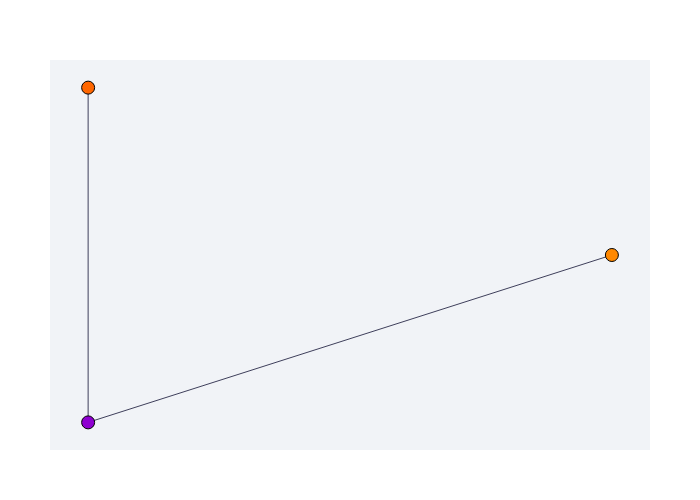

In [6]:
DrawGraph(S2_L1)

After the grid has been created it can be passed to the function `GetSystem()`, which then returns the system matrices for the state-space representation in the continous-time domain.

In [8]:
A, B, C, D = GetSystem(S2_L1);

We convert the matrices into the discrete-time domain and create a discrete StateSpace object with the help of `ControlSystems`. This object can then represent the dynamics of the system for a given time interval using the function `lsim()`.

In [9]:
ts = 1e-5
Ad = exp(A*ts)
Bd = A \ (Ad - C) * B
sys_d = StateSpace(Ad, Bd, C, D, ts);

To use `lsim()` you need defined initial states `x0`, a time vector `t` and a input signal `u`. In our case we apply a jump to 250 V to the system.

In [10]:
ns = length(A[1,:]) # get num of states
ni = length(B[1,:]) # get num of inputs
t = collect(0:ts:0.1)
x0 = [0.0 for i = 1:ns]
u = [250.0 for i = 1:length(t)]
uu = [u for i = 1:ni ]
uuu = mapreduce(permutedims, vcat, uu);

`lsim()` now solves the difference equations for the given time steps and we can observe how the states evolve.

In [11]:
xout, _, _, _ = lsim(sys_d,uuu,t,x0=x0);

Here, we plot the voltage across the capacitor in the first source.

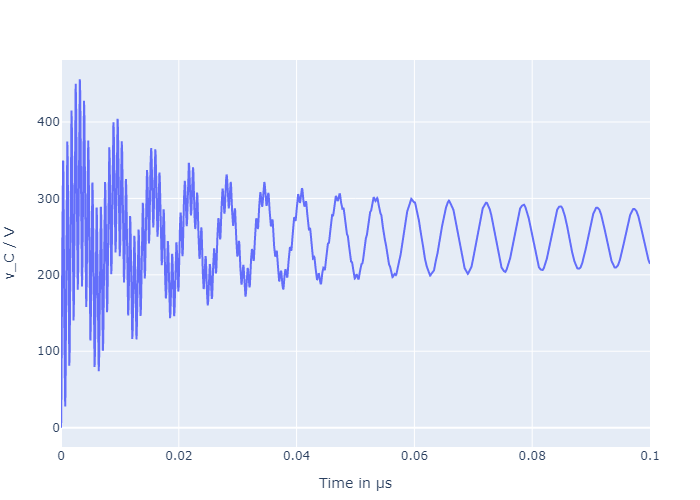

In [12]:
layout = Layout(xaxis_title="Time in µs", yaxis_title="v_C / V")
p = plot(t, xout[2,:], layout)

### Random Grid Generation 

The manual creation of a grid can be time consuming because all parameters have to be specified. To quickly create different topologies with little effort, automatic generation can be used. One needs to set only the number of sources and loads, all other parameters are set by default or are randomly selected. An important feature is the creation of random node structures, where the parameters of the elements are chosen randomly.

In [13]:
S2_L2_FC = NodeConstructor(num_sources=2, num_loads=2);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



To create the `CM` matrix randomly, the parameters `S2S_p`, `L2L_p` and `S2L_p` can also be used to set the connection probabilities. These indicate the probability with which a source/load will be connected to any other source/load. A fully connected grid would be obtained if all parameters are set to 1.

In [14]:
S2_L2_FC = NodeConstructor(num_sources=2, num_loads=2, S2S_p=1, S2L_p=1, L2L_p=1);

Let's check the `CM` matrix.

In [15]:
S2_L2_FC.CM

4×4 Matrix{Float64}:
  0.0   1.0   2.0  3.0
 -1.0   0.0   4.0  5.0
 -2.0  -4.0   0.0  6.0
 -3.0  -5.0  -6.0  0.0

With a look into the parameter dict we also see that the parameters of the individual elements were randomly generated. The current policy for the sources is that an LC filter is always taken and the other filter types are chosen randomly.

In [16]:
S2_L2_FC.parameters["source"]

2-element Vector{Any}:
 Dict{Any, Any}("L1" => 683065.1506262049, "C" => 770.6152043421689, "mode" => "Synchronverter", "fltr" => "LC", "pwr" => 10000.0, "source_type" => "ideal", "R_C" => 9.924097510713226, "std_asy" => 2500.0, "σ" => 0.0, "i_limit" => 34.78900639704982…)
 Dict{Any, Any}("L1" => 227688.38354206827, "mode" => "Synchronverter", "fltr" => "L", "pwr" => 30000.0, "source_type" => "ideal", "std_asy" => 7500.0, "σ" => 0.0, "i_limit" => 104.36701919114945, "v_rip" => 0.01537, "v_δ_set" => 0.0…)

For larger networks, of course, only the number of sources and loads can be handed over, so that the network structures are created on the basis of the default values. An important point here is that it is ensured that no subnets are created. By default, it is ensured that each element of the network has at least one connection to the other components of the network, so that no subnetworks are created.

Internally, this is done by checking for connections for each element. If these are not present, they are automatically created. For smaller networks it is advisable to specify a `CM` matrix, because otherwise usually too many connections are made than necessary. However, this is no longer noticeable with more than 10+ elements.

In [20]:
S5_L15 = NodeConstructor(num_sources=5, num_loads=15); # depending on your system, this may take a while

In [18]:
S5_L15.CM

20×20 Matrix{Float64}:
   0.0    0.0    0.0    0.0    0.0  …  10.0  11.0  12.0  13.0  14.0  15.0
   0.0    0.0    0.0    0.0    0.0     25.0  26.0  27.0  28.0  29.0  30.0
   0.0    0.0    0.0    0.0    0.0     40.0  41.0  42.0  43.0  44.0  45.0
   0.0    0.0    0.0    0.0    0.0     55.0  56.0  57.0  58.0  59.0  60.0
   0.0    0.0    0.0    0.0    0.0     70.0  71.0  72.0  73.0  74.0  75.0
  -1.0  -16.0  -31.0  -46.0  -61.0  …   0.0   0.0   0.0   0.0   0.0   0.0
  -2.0  -17.0  -32.0  -47.0  -62.0      0.0   0.0   0.0   0.0   0.0   0.0
  -3.0  -18.0  -33.0  -48.0  -63.0      0.0   0.0   0.0   0.0   0.0   0.0
  -4.0  -19.0  -34.0  -49.0  -64.0      0.0   0.0   0.0   0.0   0.0   0.0
  -5.0  -20.0  -35.0  -50.0  -65.0      0.0   0.0   0.0   0.0   0.0   0.0
  -6.0  -21.0  -36.0  -51.0  -66.0  …   0.0   0.0   0.0   0.0   0.0   0.0
  -7.0  -22.0  -37.0  -52.0  -67.0      0.0   0.0   0.0   0.0   0.0   0.0
  -8.0  -23.0  -38.0  -53.0  -68.0      0.0   0.0   0.0   0.0   0.0   0.0
  -9.0  -24.0  

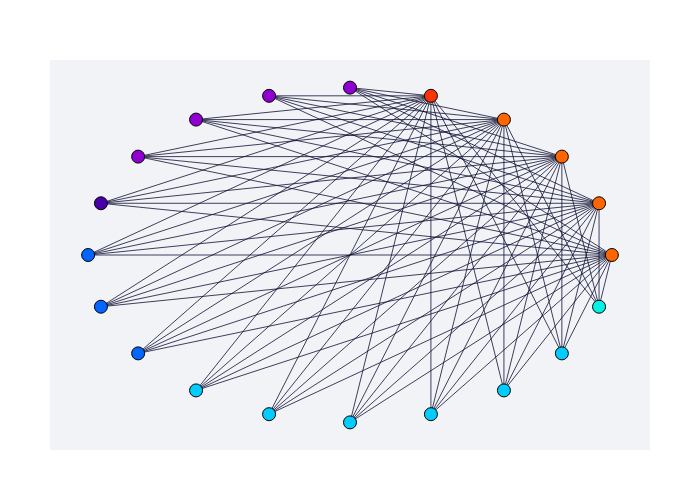

In [19]:
DrawGraph(S5_L15)

## Three-phase simulation

Until now, only single-phase grids have been created with NodeConstructor. However, the default value for the number of phases is 3, so we will now also consider the three-phase variant. For the simulation of the grid in 3 phases the system matrix is extended:

\begin{equation}
A_{all} = \begin{pmatrix}
        A_{a} & 0 & 0 \\
        0 & A_{b} & 0 \\
        0 & 0 & A_{c} 
    \end{pmatrix}
\end{equation}

Lets see how this looks like in Julia.

In [21]:
S1_L2 = NodeConstructor(num_sources=1, num_loads=2);

In [22]:
S1_L2.parameters["grid"]["phase"]

3

In [23]:
A, B, C, D = GetSystem(S1_L2)
ts = 1e-4
Ad = exp(A*ts)
Bd = A \ (Ad - C) * B
sys_d = StateSpace(Ad, Bd, C, D, ts);

We then collect a few useful variables and set the time horizon for the simulation.

In [24]:
ns = S1_L2.num_spp  # get num of states per phase
ni = S1_L2.num_sources # get num of inputs per phase
t = collect(0:ts:1);

Next, we want to generate the three-phase input signals and repeat it for the number of sources:

In [25]:
# Stepfunction
u = sqrt(2)*[230, 0, -230]
uu = repeat(u, inner=ni) .* ones(length(t))';

In [26]:
# Sinusoidal signals
u = [230 * sin.(2*pi*t .- 2/3*pi*(i-1)) for i = 1:3]
uu = transpose(hcat(repeat(u[1], inner=[1,ni]),repeat(u[2], inner=[1,ni]),repeat(u[3], inner=[1,ni])));

Lets have a look:

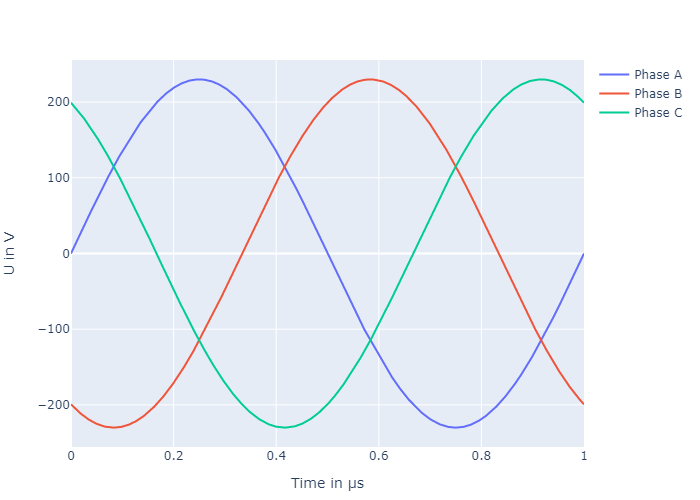

In [27]:
layout = Layout(xaxis_title="Time in µs", yaxis_title="U in V")
input = 1

phase_a = scatter(x=t, y=uu[input+ni*0,:], mode="lines", name="Phase A")
phase_b = scatter(x=t, y=uu[input+ni*1,:], mode="lines", name="Phase B")
phase_c = scatter(x=t, y=uu[input+ni*2,:], mode="lines", name="Phase C")

plot([phase_a, phase_b, phase_c], layout)

Again, the discretised matrices can now be used to model the grid.

In [28]:
x0 = [0.0 for i = 1:ns*3]
xout, _, _, _ = lsim(sys_d,uu,t,x0=x0);

Now, a state can be selected and the corresponding trajectories can be plotted.

In [29]:
state_list = GetStateIds(S1_L2);

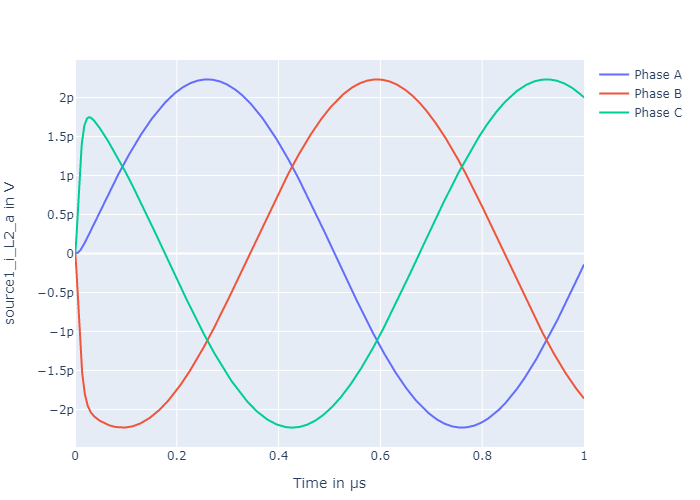

In [30]:
state = 3
state_list = GetStateIds(S1_L2)

layout = Layout(xaxis_title="Time in µs", yaxis_title="$(state_list[state]) in V")

phase_a = scatter(x=t, y=xout[state+ns*0,:], mode="lines", name="Phase A")
phase_b = scatter(x=t, y=xout[state+ns*1,:], mode="lines", name="Phase B")
phase_c = scatter(x=t, y=xout[state+ns*2,:], mode="lines", name="Phase C")

plot([phase_a, phase_b, phase_c], layout)


### Access to the different states

A way to get the different states of our NodeConstructor is to use the function `GetStateIds()`.

In [31]:
state_list = GetStateIds(S1_L2)

30-element Vector{String}:
 "source1_i_L1_a"
 "source1_v_C_filt_a"
 "source1_i_L2_a"
 "source1_v_C_cables_a"
 "cable1_i_L_a"
 "cable2_i_L_a"
 "load1_v_C_total_a"
 "load1_i_L_a"
 "load2_v_C_total_a"
 "load2_i_L_a"
 ⋮
 "source1_v_C_filt_c"
 "source1_i_L2_c"
 "source1_v_C_cables_c"
 "cable1_i_L_c"
 "cable2_i_L_c"
 "load1_v_C_total_c"
 "load1_i_L_c"
 "load2_v_C_total_c"
 "load2_i_L_c"

The IDs created here are unique and can be used to access particular states. When creating the IDs, the sources are checked first in the order LCL, LC and then L. Then the cables are listed, which are also arranged in order. For the loads the order is RLC, LC, RL, L, RC, C and then R.

For the three-phase case, the state IDs are repeated and the respective phase is added.

These can then be accessed as follows:

In [32]:
state = 3
println(state_list[state+ns*0])
println(state_list[state+ns*1])
println(state_list[state+ns*2])

source1_i_L2_a
source1_i_L2_b
source1_i_L2_c


Or:

In [33]:
state = "source1_i_L1"
idx_of_state = findall(x->occursin(state, x), state_list)
idx = idx_of_state

3-element Vector{Int64}:
  1
 11
 21

In [34]:
state = "source1_i_L1_a"
idx_of_state = findall(x->occursin(state, x), state_list)
idx = idx_of_state

1-element Vector{Int64}:
 1

The actions in the grid are also assigned unique IDs, here the sources are sorted in order. The IDs are output via the function `GetActionIds()`.

In [35]:
GetActionIds(S1_L2)

3-element Vector{String}:
 "source1_u_a"
 "source1_u_b"
 "source1_u_c"